# Test comparison across models

Notebook for comparing models on held-out block of data (cold semester 2024-2025)

### Final Model Testing Procedure

Model testing is performed using cross-validation, specifically targeting the **cold season of 2024–2025**.

* For the **weekly forecast horizon**, we use approximately **20 test windows**.
* For the **daily forecast horizon**, we use around **35 test windows**.

The number of windows for the weekly horizon is intentionally kept lower to reduce overlap and correlation between neighboring test periods.

In each cross-validation fold:

* The model is trained on all historical data **prior to the test window**.
* It is then evaluated on the **test window itself**, using various error metrics.

The **exact number of windows**, along with the **start and end dates** of the test period, may vary slightly across different time series. However, for all cases, the cross-validation design follows these principles:

* Testing begins **after the summer**, when heat demand starts to rise, and ends **in spring**, as demand decreases.
* The **step size** between folds is:

  * **9 days** for weekly forecasts
  * **5 days** for daily forecasts

This setup ensures thorough evaluation during the periods of highest relevance for heating demand.


### Evaluation Summary


The evaluation results reveal the following key insights:

1. **SARIMAX performs comparably to the company’s existing machine learning models**, indicating that a well-calibrated statistical model can match the performance of more complex, ML-based approaches.

2. **MSTL performs similarly to the naïve baseline across most time series**, with the notable exception of **series F5**, where it comes close to SARIMAX. This can be attributed to F5's pronounced **weekly seasonality**, which MSTL captures effectively, unlike the naïve model. This suggests that **MSTL is particularly well-suited as a baseline model for time series with strong weekly patterns**.

## Import Libreries and Data

In [30]:
import sys, numpy, numba
print("Python      :", sys.version.split()[0])
print("NumPy       :", numpy.__version__)
print("Numba       :", numba.__version__)

Python      : 3.12.9
NumPy       : 2.2.6
Numba       : 0.61.2


In [31]:
import subprocess
from pathlib import Path

# Detect if running on Google Colab
def in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

# Set base directory and handle environment
if in_colab():
    # Install required packages only if not already installed
    def install(package):
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    for pkg in ["statsmodels", "statsforecast", "mlforecast"]:
        install(pkg)

    # Mount Google Drive
    from google.colab import drive  # type: ignore
    drive.mount('/content/drive')

    # Set base directory to your Drive project folder
    BASE_DIR = Path('/content/drive/MyDrive/heat-forecast')

    # Add `src/` to sys.path for custom package imports
    src_path = BASE_DIR / 'src'
    if str(src_path) not in sys.path:
        sys.path.append(str(src_path))

else:
    # Local/VM setup: assume notebook is in project_root/notebooks/
    BASE_DIR = Path.cwd().parent

In [32]:
# --- IPython Magic ---
%load_ext autoreload
%autoreload 2

# --- Standard Library ---
import sys
import yaml
import warnings
import logging
from collections import defaultdict
from datetime import datetime

# --- Logging Configuration ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%H:%M:%S",
    force=True,
    stream=sys.stdout
)

# --- Data Handling ---
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)

# --- Plotting & Visualization ---
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# Set plot style and parameters
plt.style.use("ggplot")
palette = sns.color_palette("tab10", 5)
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 18
})
mpl.rcParams['axes.prop_cycle'] = cycler(color=["#000000", "#000000"])
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'both'

# --- Forecasting Models ---
from statsforecast import StatsForecast
from statsforecast.models import SeasonalNaive

# --- Project-Specific Utilities ---
from heat_forecast.utils.plotting import interactive_plot_cutoff_results
from heat_forecast.utils.evaluation import (
    custom_evaluate_cv, display_cv_summary, plot_cv_metric_by_cutoff,
    compute_loss_diff_stats,
)
from heat_forecast.utils.cv_utils import display_info_cv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
heat_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'heat.csv'
aux_path = BASE_DIR / 'data' / 'timeseries_preprocessed' / 'auxiliary.csv'
heat_df = pd.read_csv(heat_path, parse_dates=['ds'])
aux_df = pd.read_csv(aux_path, parse_dates=['ds'])

## Load Saved Test Results

In [34]:
TESTS_DIR = BASE_DIR / 'results' / 'test'
cv_groups = defaultdict(list)    # {(Fi, horizon): [(cv_df, run_dir)]}
run_tracker = defaultdict(list)  # {(model, Fi, horizon): [(timestamp, run_dir)]}
model_folder_to_name_map = {
    "mstl": "MSTL",
    "sarimax": "SARIMAX",
    "lstm": "LSTM",
}
cutoffs = None  # Will be set to the unique cutoffs from the first loaded DataFrame

# ----------- Collect all valid run_dirs -----------
for model_dir in TESTS_DIR.iterdir():
    if not model_dir.is_dir():
        continue

    for run_dir in model_dir.iterdir():
        if not run_dir.is_dir():
            logging.warning(f"Unexpected non-directory in folder: {run_dir.relative_to(BASE_DIR)}. "
                            f"Non-directory: {run_dir}.")
            continue

        parts = run_dir.name.split('_')
        if len(parts) < 3 or not parts[0].startswith('F'):
            logging.warning(f"Skipping folder {run_dir.relative_to(BASE_DIR)} due to unexpected format. "
                            f"Folder name: {run_dir.name}. "
                            f"Expected format: <unique_id>_<horizon_type>_test_<model_name>_<timestamp>.")
            continue

        fi = parts[0]
        horizon = parts[1]
        timestamp_str = parts[-1]
        if model_dir.name not in model_folder_to_name_map.keys():
            logging.warning(f"Model for folder '{model_dir.name}' not recognized. "
                            f"Update the dict model_folder_to_name_map at the top of this cell."
                            f"Using folder name as model name.")
        model = model_folder_to_name_map.get(model_dir.name, model_dir.name)

        try:
            timestamp = datetime.strptime(timestamp_str, "%Y%m%dT%H%M%S")
        except ValueError:
            logging.warning(f"Skipping run with invalid timestamp: {run_dir}")
            continue

        run_tracker[(model, fi, horizon)].append((timestamp, run_dir))

# ----------- Select latest runs and load them -----------
for key, runs in run_tracker.items():
    model, fi, horizon = key
    runs_sorted = sorted(runs, key=lambda x: x[0], reverse=True)

    if len(runs_sorted) > 1:
        logging.warning(f"Multiple runs found for model={model}, id={fi}, horizon={horizon}. Using latest only.")

    latest_run_dir = runs_sorted[0][1]
    cv_path = latest_run_dir / "cv_df.parquet"

    if not cv_path.exists():
        logging.warning(f"cv_df.parquet not found for latest run: {latest_run_dir}")
        continue

    try:
        df = pd.read_parquet(cv_path)
    except Exception as e:
        warnings.warn(f"Failed to load {cv_path}: {e}")
        raise

    if not {'unique_id', 'ds'}.issubset(df.columns):
        raise ValueError(f"DataFrame from {cv_path} does not contain required columns ['unique_id', 'ds']")

    df.drop(columns=['y'], inplace=True, errors='ignore')  # Drop 'y' column if it exists
    df = df.set_index(['unique_id', 'ds', 'cutoff'])
    df.index.names = ['unique_id', 'ds', 'cutoff']
    cv_groups[(fi, horizon)].append((df, latest_run_dir, model))

# Build tidy records
rows = []
for (fi, horizon), values in cv_groups.items():
    for el in values:
        rows.append({
            "unique_id": fi,
            "horizon": horizon,
            "model": el[2],
            "run": str(el[1].relative_to(TESTS_DIR)),
        })

# Log it nicely
df = (
    pd.DataFrame(rows)
      .sort_values(["unique_id", "horizon", "model", "run"])
      .reset_index(drop=True)
)
df = df.set_index(["unique_id", "horizon", "model"])[["run"]]
with pd.option_context("display.max_rows", None, "display.width", 160):
    logging.info("Successfully selected the following runs:")
    display(df)

# ----------- Merge DataFrames -----------
merged_results_tmp = {} # {(Fi, horizon): (merged_df, for_cv)}

for (fi, horizon), value in cv_groups.items():
    dfs, run_dirs, models = zip(*value)  
    merged_df = dfs[0]
    
    metadata_path = run_dirs[0] / 'metadata.yaml'
    try:
        with open(metadata_path, 'r') as f:
            metadata = yaml.safe_load(f)
    except FileNotFoundError:
        logging.warning(f"Metadata file not found for {run_dirs[0]}.")
        raise

    step_size_first = metadata.get('for_cv', {}).get('step_size', None)
    if step_size_first is None: 
        raise ValueError(f"Metadata for step_size not found in {metadata_path}")
    test_hours_first = metadata.get('for_cv', {}).get('test_hours', None)
    if test_hours_first is None: 
        raise ValueError(f"Metadata for test_hours not found in {metadata_path}")
    end_test_cv_first = metadata.get('for_cv', {}).get('end_test_cv', None)
    if test_hours_first is None: 
        raise ValueError(f"Metadata for end_test_cv not found in {metadata_path}")

    # Ensure all tests were generate using the same cv params
    for i in range(1, len(dfs)):
        df = dfs[i]

        metadata_path = run_dirs[i] / 'metadata.yaml'
        try:
            with open(metadata_path, 'r') as f:
                metadata = yaml.safe_load(f)
        except FileNotFoundError:
            logging.warning(f"Metadata file not found for {run_dirs[i]}.")
            raise

        step_size = metadata.get('for_cv', {}).get('step_size', None)
        if step_size is None:
            raise ValueError(f"Metadata for step_size not found in {metadata_path}")
        test_hours = metadata.get('for_cv', {}).get('test_hours', None)
        if test_hours is None:
            raise ValueError(f"Metadata for test_hours not found in {metadata_path}")
        end_test_cv = metadata.get('for_cv', {}).get('end_test_cv', None)
        if end_test_cv is None:
            raise ValueError(f"Metadata for end_test_cv not found in {metadata_path}")
        
        if step_size != step_size_first:
            raise ValueError(f"Step size from {run_dirs[0]} and {run_dirs[i]} do not match.")
        if test_hours != test_hours_first:
            raise ValueError(f"Test hours from {run_dirs[0]} and {run_dirs[i]} do not match.")
        if end_test_cv != end_test_cv_first:
            raise ValueError(f"End test cv from {run_dirs[0]} and {run_dirs[i]} do not match.")
        
        merged_df = merged_df.join(df, how='outer')

    for_cv = {
        'step_size': step_size_first,
        'test_hours': test_hours_first,
        'end_test_cv': end_test_cv_first,
    }

    merged_df = merged_df.reset_index()
    merged_results_tmp[(fi, horizon)] = (merged_df, for_cv)

merged_results = {}  # {(Fi, horizon): merged_df}

# ----------- Add Naive forecast -----------
for (fi, horizon), (df, for_cv) in merged_results_tmp.items():
    naive_model = SeasonalNaive(season_length=24, alias='Naive24h')
    sf = StatsForecast(models=[naive_model], freq='h')

    heat_id_df = heat_df[heat_df['unique_id'] == fi].copy()
    
    h = 24*7 if horizon == 'week' else 24
    step_size = for_cv['step_size']
    test_hours = for_cv['test_hours']
    end_test_cv = for_cv['end_test_cv']
    n_windows = (test_hours - h) // step_size + 1
    full_df = heat_id_df[heat_id_df['ds'] <= end_test_cv]  

    cv_naive = sf.cross_validation(
        h=h,
        df=full_df,
        n_windows=n_windows,
        step_size=step_size,  
        test_size=test_hours,  
        input_size=None,  
        refit=True,  
    )

    df = df.merge(
        cv_naive,
        on=['unique_id', 'ds', 'cutoff'],
        how='outer',
    )

    merged_results[(fi, horizon)] = df.copy()

21:02:39 | WARNING | root | Multiple runs found for model=LSTM, id=F1, horizon=day. Using latest only.
21:02:39 | WARNING | root | Multiple runs found for model=LSTM, id=F5, horizon=day. Using latest only.
21:02:39 | INFO | root | Successfully selected the following runs:


run
unique_id horizon model                                                
F1        day     LSTM            lstm\F1_day_test_lstm_20250905T095129
                  MSTL            mstl\F1_day_test_mstl_20250720T175126
                  SARIMAX   sarimax\F1_day_test_sarimax_20250719T234609
          week    MSTL           mstl\F1_week_test_mstl_20250720T174752
                  SARIMAX  sarimax\F1_week_test_sarimax_20250719T232712
F2        day     LSTM            lstm\F2_day_test_lstm_20250905T113004
                  MSTL            mstl\F2_day_test_mstl_20250720T175944
                  SARIMAX   sarimax\F2_day_test_sarimax_20250720T003510
          week    MSTL           mstl\F2_week_test_mstl_20250720T175801
                  SARIMAX  sarimax\F2_week_test_sarimax_20250720T001906
F3        day     LSTM            lstm\F3_day_test_lstm_20250905T113737
                  MSTL            mstl\F3_day_test_mstl_20250720T180710
                  SARIMAX   sarimax\F3_day_test_sarimax_20250720T012041
          week    MSTL           mstl\F3_week_test_mstl_20250720T180353
                  SARIMAX  sarimax\F3_week_test_sarimax_20250720T010337
F4        day     LSTM            lstm\F4_day_test_lstm_20250921T193029
                  MSTL            mstl\F4_day_test_mstl_20250720T181521
                  SARIMAX   sarimax\F4_day_test_sarimax_20250720T015919
          week    MSTL           mstl\F4_week_test_mstl_20250720T181315
                  SARIMAX  sarimax\F4_week_test_sarimax_20250720T015217
F5        day     LSTM            lstm\F5_day_test_lstm_20250921T204748
                  MSTL            mstl\F5_day_test_mstl_20250720T182300
                  SARIMAX   sarimax\F5_day_test_sarimax_20250720T022943
          week    MSTL           mstl\F5_week_test_mstl_20250720T181956
                  SARIMAX  sarimax\F5_week_test_sarimax_20250720T021112

## Series F1

### Daily horizon

In [35]:
cv_df = merged_results[('F1', 'day')]
display_info_cv(cv_df)

21:02:47 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
───────────────────────────────────────────────────────
Models                  : LSTM, MSTL, Naive24h, SARIMAX
Unique IDs              : F1
Horizon length (hours)  : 24
Windows                 : 37
First cutoff            : 2024-10-19 23:00
Last cutoff             : 2025-04-17 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [36]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [9]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

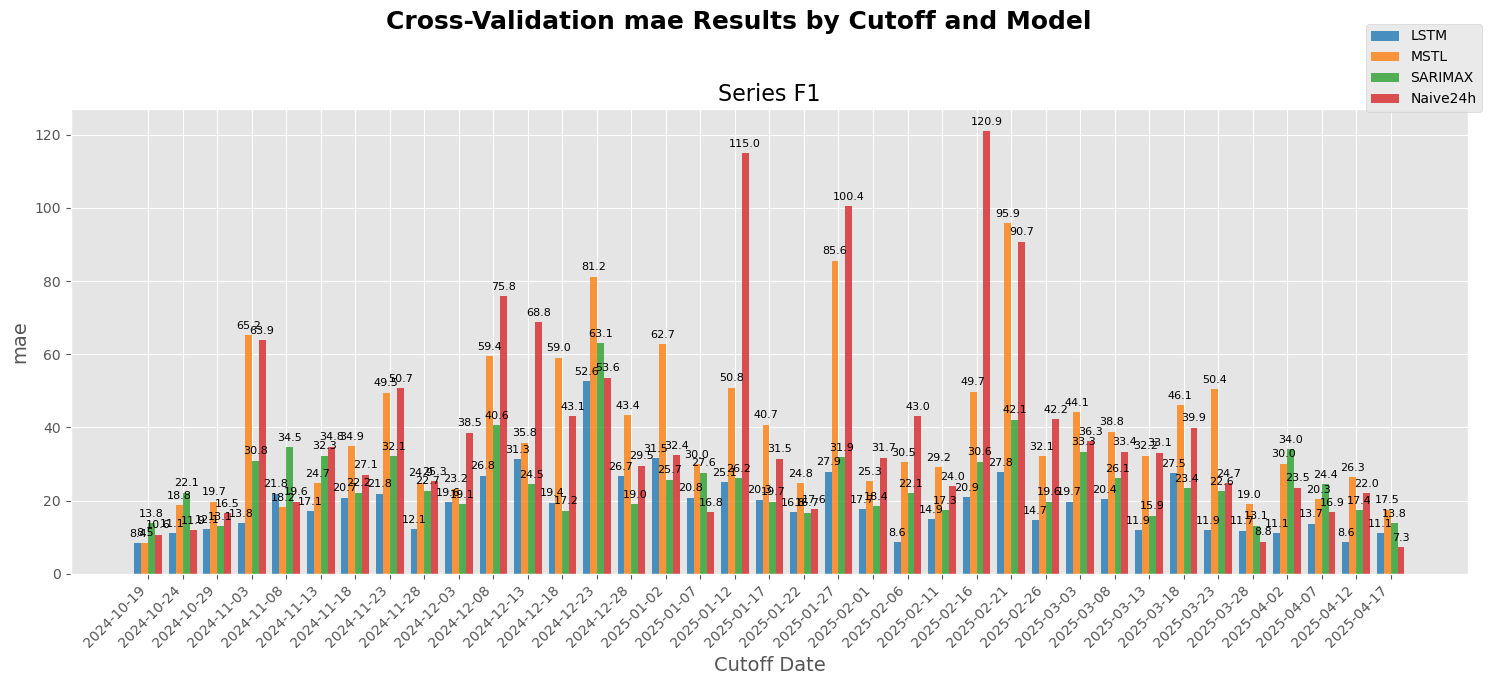

In [10]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [11]:
# exclude last and first n windows
n = 5
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n:-n]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

19:18:07 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
───────────────────────────────────────────────────────
Models                  : LSTM, MSTL, Naive24h, SARIMAX
Unique IDs              : F1
Horizon length (hours)  : 24
Windows                 : 27
First cutoff            : 2024-11-13 23:00
Last cutoff             : 2025-03-23 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [12]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [13]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [38]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=1,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 10),
    models=["LSTM", "SARIMAX"]
)

interactive(children=(IntSlider(value=18, continuous_update=False, description='Cutoff idx:', max=36), Output(…

### Weekly horizon

In [39]:
cv_df = merged_results[('F1', 'week')]
display_info_cv(cv_df)

14:57:56 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F1
Horizon length (hours)  : 168
Windows                 : 21
First cutoff            : 2024-10-19 23:00
Last cutoff             : 2025-04-17 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [48]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [49]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

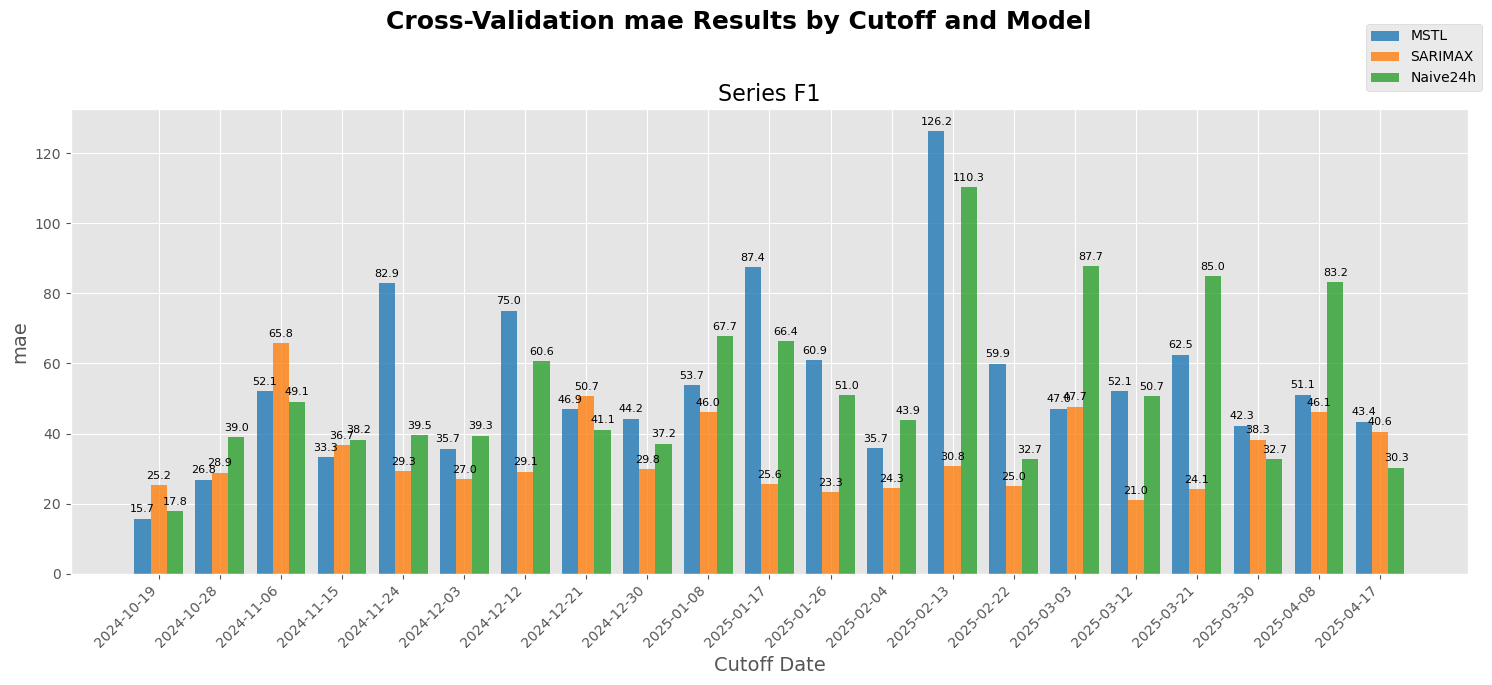

In [50]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [51]:
# exclude last and first n windows
n = 3
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n:-n]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:18:29 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F1
Horizon length (hours)  : 168
Windows                 : 15
First cutoff            : 2024-11-15 23:00
Last cutoff             : 2025-03-21 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [52]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [53]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [54]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=2,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Cutoff idx:', max=20), Output(…

## Series F2

### Daily horizon

In [46]:
cv_df = merged_results[('F2', 'day')]
display_info_cv(cv_df)

14:58:49 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
───────────────────────────────────────────────────────
Models                  : LSTM, MSTL, Naive24h, SARIMAX
Unique IDs              : F2
Horizon length (hours)  : 24
Windows                 : 37
First cutoff            : 2024-10-19 23:00
Last cutoff             : 2025-04-17 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [14]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [48]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

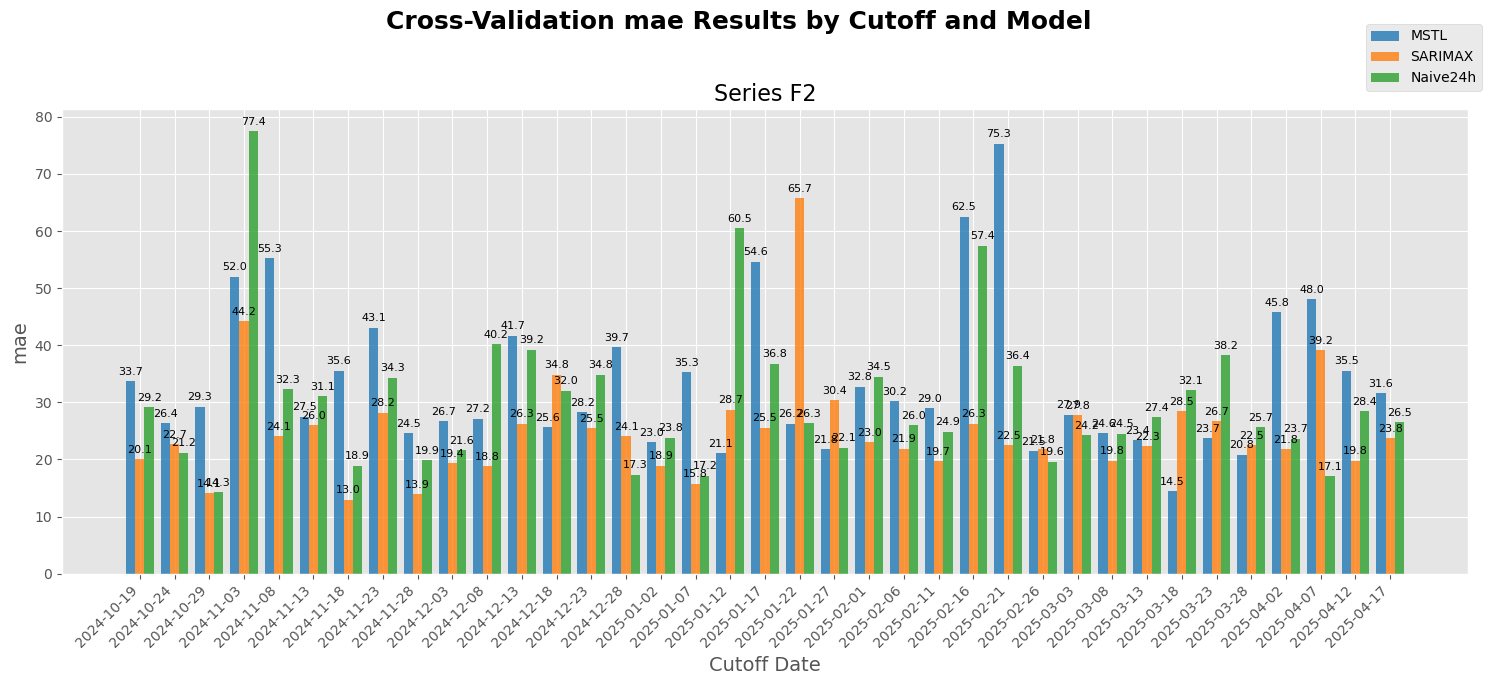

In [58]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [59]:
# exclude last and first n windows
n = 5
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n:-n]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:18:34 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F2
Horizon length (hours)  : 24
Windows                 : 27
First cutoff            : 2024-11-13 23:00
Last cutoff             : 2025-03-23 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [15]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [61]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [62]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=3,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 10)
)

interactive(children=(IntSlider(value=18, continuous_update=False, description='Cutoff idx:', max=36), Output(…

### Weekly horizon

In [63]:
cv_df = merged_results[('F2', 'week')]
display_info_cv(cv_df)

18:18:37 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F2
Horizon length (hours)  : 168
Windows                 : 21
First cutoff            : 2024-10-19 23:00
Last cutoff             : 2025-04-17 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [64]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [65]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

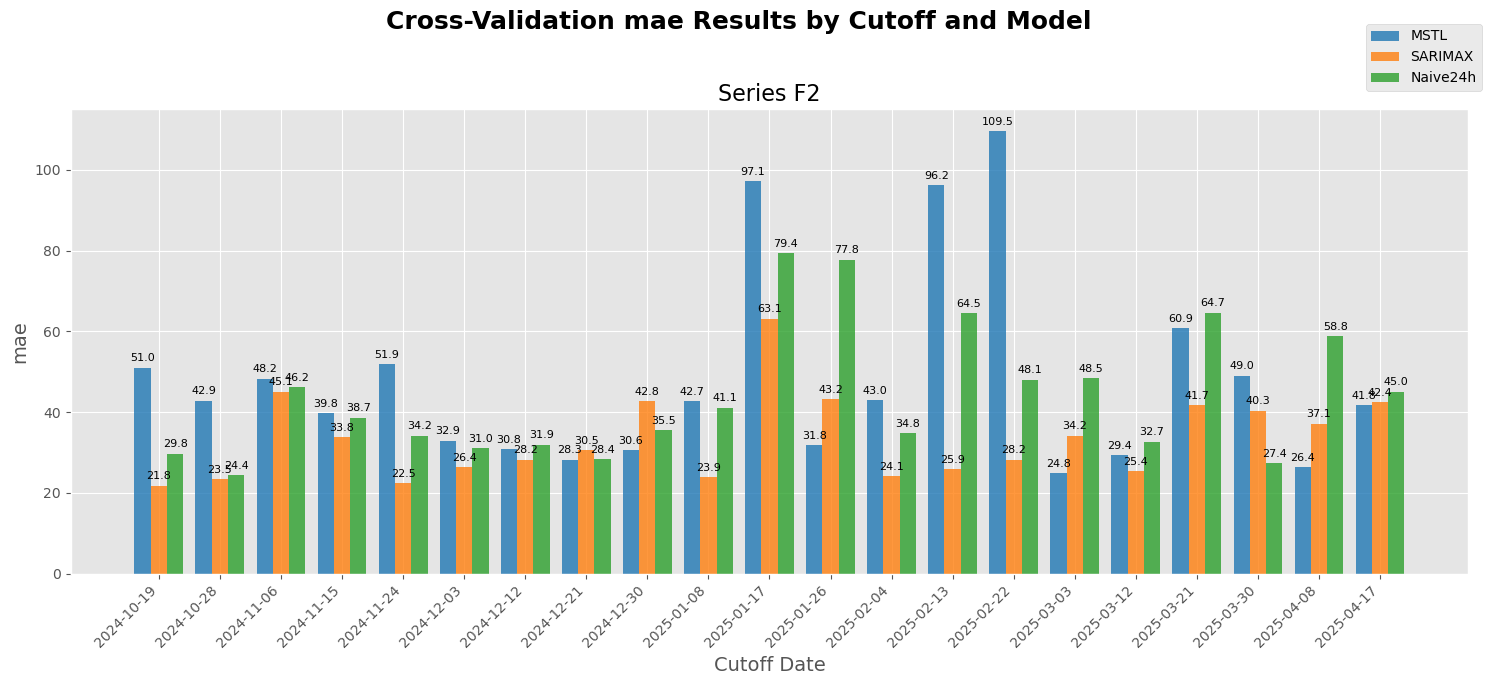

In [66]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [67]:
# exclude last and first n windows
n = 3
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n:-n]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:18:38 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F2
Horizon length (hours)  : 168
Windows                 : 15
First cutoff            : 2024-11-15 23:00
Last cutoff             : 2025-03-21 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [68]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [69]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [70]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=3,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Cutoff idx:', max=20), Output(…

## Series F3

### Daily horizon

In [37]:
cv_df = merged_results[('F3', 'day')]
display_info_cv(cv_df)

21:03:03 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
───────────────────────────────────────────────────────
Models                  : LSTM, MSTL, Naive24h, SARIMAX
Unique IDs              : F3
Horizon length (hours)  : 24
Windows                 : 35
First cutoff            : 2024-10-27 23:00
Last cutoff             : 2025-04-15 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [38]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [73]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

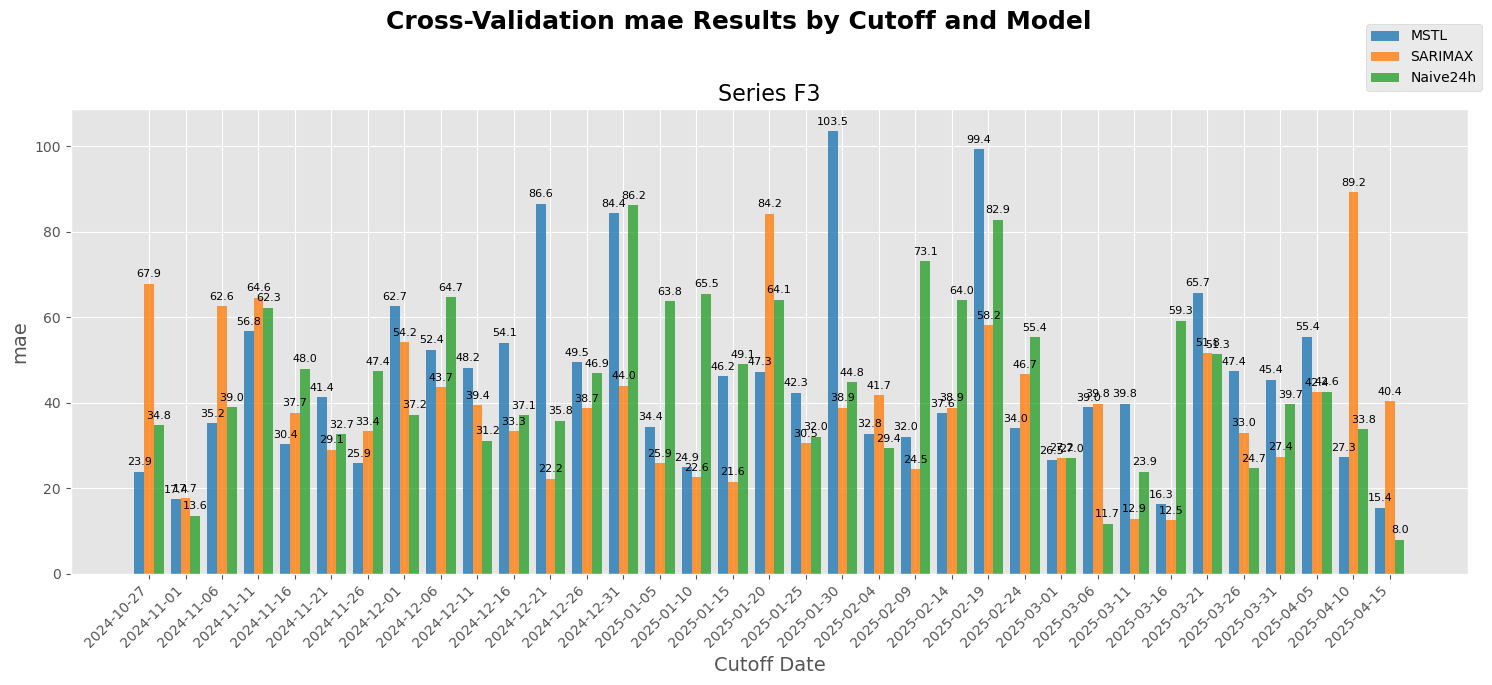

In [74]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [75]:
# exclude last and first n windows
n = 5
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n:-n]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:18:43 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F3
Horizon length (hours)  : 24
Windows                 : 25
First cutoff            : 2024-11-21 23:00
Last cutoff             : 2025-03-21 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [76]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [77]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [78]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=6,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 10)
)

interactive(children=(IntSlider(value=17, continuous_update=False, description='Cutoff idx:', max=34), Output(…

### Weekly horizon

In [79]:
cv_df = merged_results[('F3', 'week')]
display_info_cv(cv_df)

18:18:46 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F3
Horizon length (hours)  : 168
Windows                 : 19
First cutoff            : 2024-10-27 23:00
Last cutoff             : 2025-04-07 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [80]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [81]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

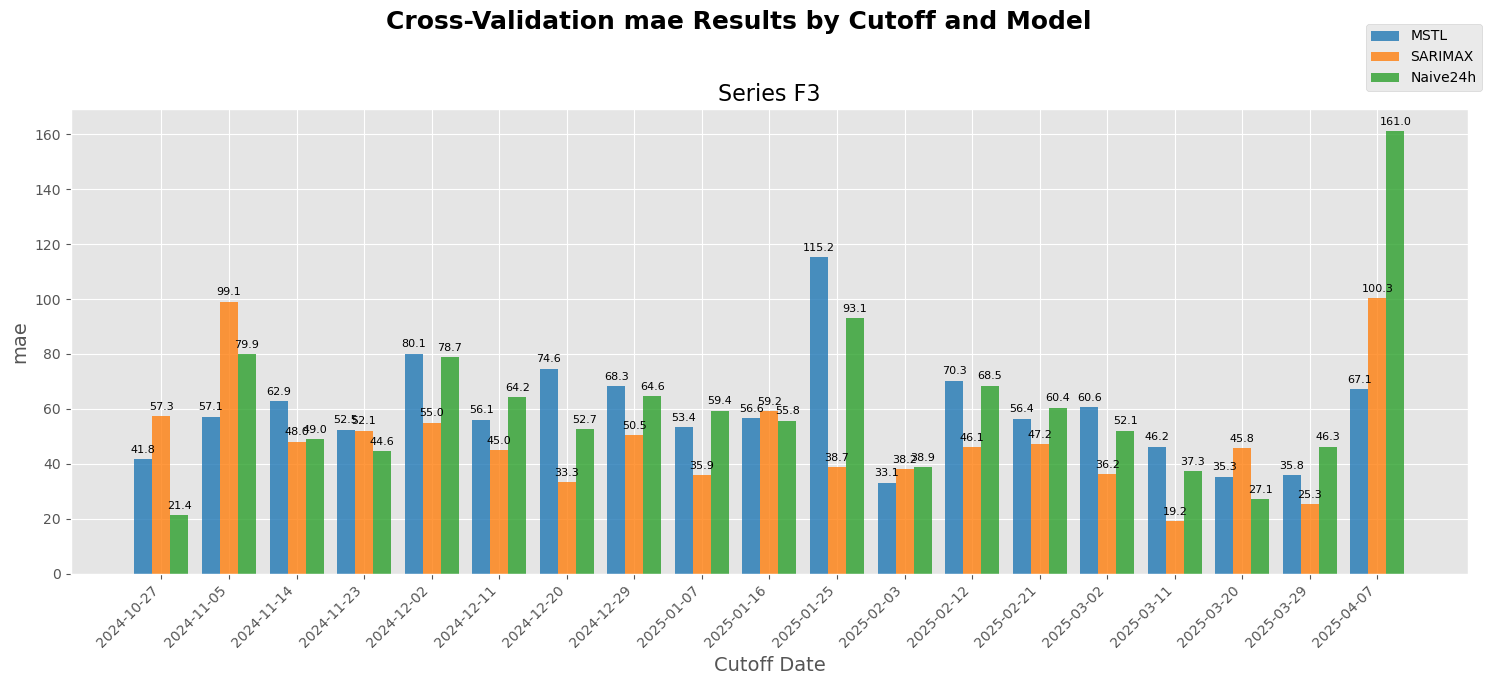

In [82]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [83]:
# exclude last and first n windows
n = 2
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n:-n]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:18:47 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F3
Horizon length (hours)  : 168
Windows                 : 15
First cutoff            : 2024-11-14 23:00
Last cutoff             : 2025-03-20 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [84]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [85]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [86]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=3,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 10)
)

interactive(children=(IntSlider(value=9, continuous_update=False, description='Cutoff idx:', max=18), Output()…

## Series F4

### Daily horizon

In [39]:
cv_df = merged_results[('F4', 'day')]
display_info_cv(cv_df)

21:03:12 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
───────────────────────────────────────────────────────
Models                  : LSTM, MSTL, Naive24h, SARIMAX
Unique IDs              : F4
Horizon length (hours)  : 24
Windows                 : 32
First cutoff            : 2024-11-09 23:00
Last cutoff             : 2025-04-13 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [40]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [89]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

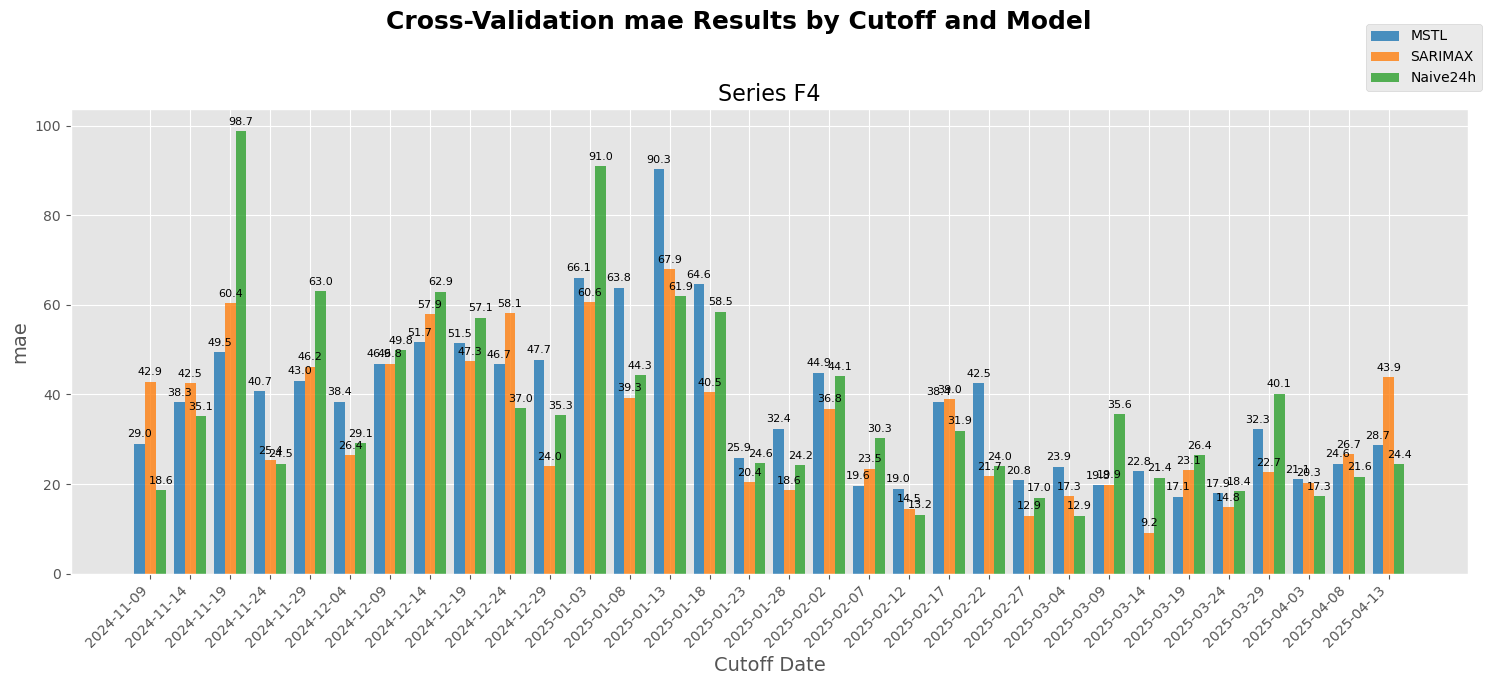

In [90]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [91]:
# exclude last and first n windows
n = 4
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n:-n]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:18:52 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F4
Horizon length (hours)  : 24
Windows                 : 24
First cutoff            : 2024-11-29 23:00
Last cutoff             : 2025-03-24 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [92]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [93]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [21]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=6,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 10)
)

interactive(children=(IntSlider(value=16, continuous_update=False, description='Cutoff idx:', max=31), Output(…

### Weekly horizon

In [22]:
cv_df = merged_results[('F4', 'week')]
display_info_cv(cv_df)

19:37:34 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F4
Horizon length (hours)  : 168
Windows                 : 18
First cutoff            : 2024-11-09 23:00
Last cutoff             : 2025-04-11 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [96]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [97]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

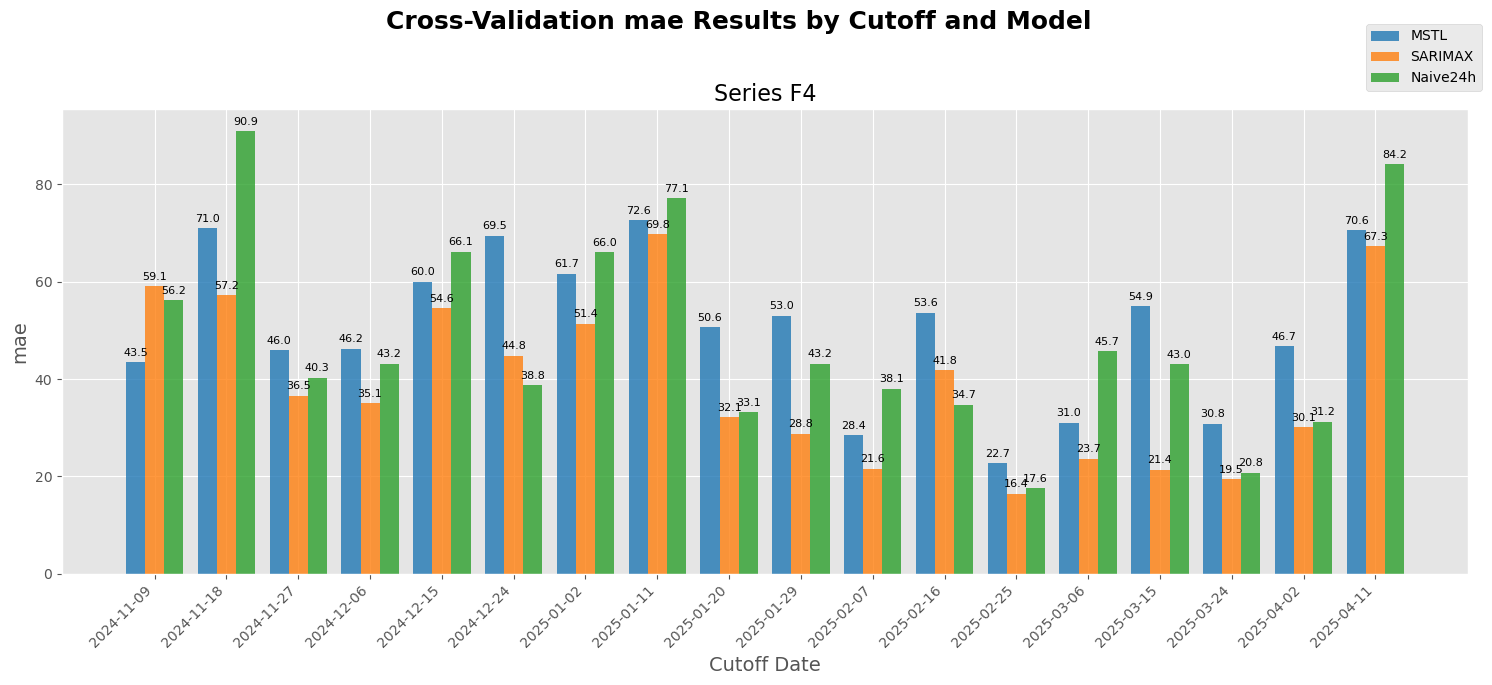

In [98]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [99]:
# exclude last and first windows
n_left = 1
n_right = 2
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n_left:-n_right]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:18:56 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F4
Horizon length (hours)  : 168
Windows                 : 15
First cutoff            : 2024-11-18 23:00
Last cutoff             : 2025-03-24 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [100]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [101]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [102]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=3,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 10)
)

interactive(children=(IntSlider(value=9, continuous_update=False, description='Cutoff idx:', max=17), Output()…

## Series F5

### Daily horizon

In [41]:
cv_df = merged_results[('F5', 'day')]
display_info_cv(cv_df)

21:03:54 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
───────────────────────────────────────────────────────
Models                  : LSTM, MSTL, Naive24h, SARIMAX
Unique IDs              : F5
Horizon length (hours)  : 24
Windows                 : 33
First cutoff            : 2024-11-09 23:00
Last cutoff             : 2025-04-18 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [42]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [43]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

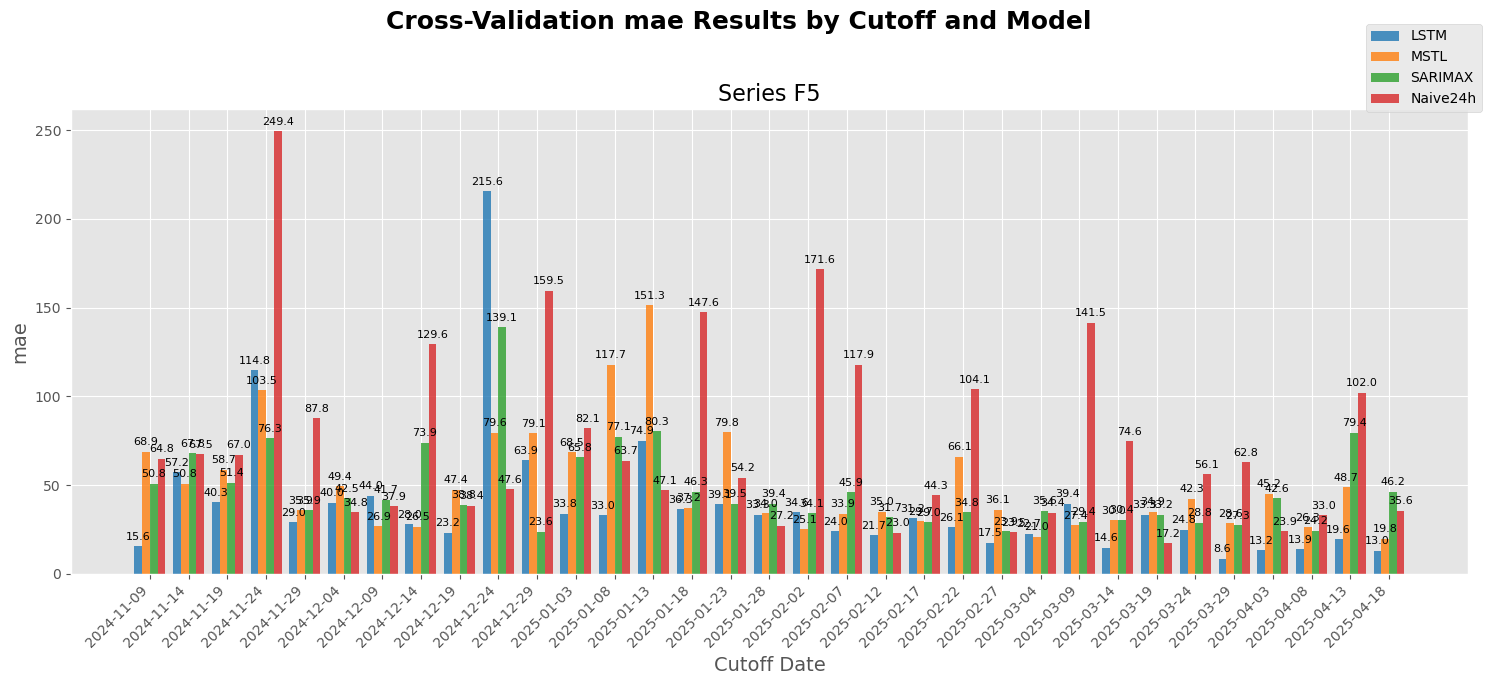

In [44]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [107]:
# exclude last and first n windows
n_left = 2
n_right = 5
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n_left:-n_right]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:19:00 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F5
Horizon length (hours)  : 24
Windows                 : 26
First cutoff            : 2024-11-19 23:00
Last cutoff             : 2025-03-24 23:00
Step size (hours)       : 5
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [108]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [109]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [110]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=6,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 10)
)

interactive(children=(IntSlider(value=16, continuous_update=False, description='Cutoff idx:', max=32), Output(…

### Weeky horizon

In [111]:
cv_df = merged_results[('F5', 'week')]
display_info_cv(cv_df)

18:19:03 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F5
Horizon length (hours)  : 168
Windows                 : 18
First cutoff            : 2024-11-09 23:00
Last cutoff             : 2025-04-11 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [112]:
summary, combined_results = custom_evaluate_cv(
    cv_df=cv_df,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary, sort_metric='mae') 

In [113]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results
)
_ = display_cv_summary(summ_ld)

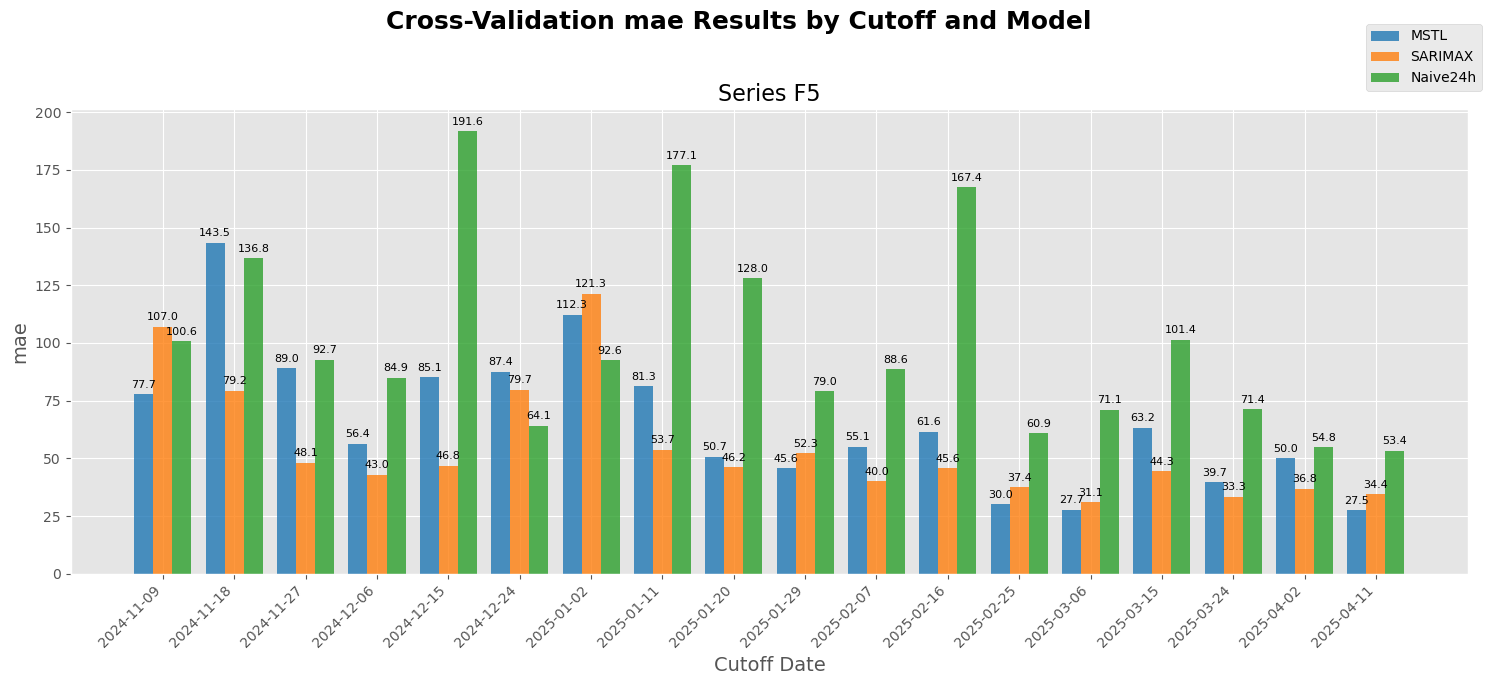

In [114]:
fig = plot_cv_metric_by_cutoff(
    combined_results=combined_results,
    metric='mae',  # Change to 'rmse' or 'me' for other metrics
)

Repeat the analysis, omitting the first and last cross-validation windows to focus on peak-demand periods.

In [115]:
# exclude last and first n windows
n_left = 1
n_right = 2
cutoffs = cv_df['cutoff'].drop_duplicates().sort_values().reset_index(drop=True)
cutoffs_to_keep = cutoffs[n_left:-n_right]
cv_df_peak = cv_df[cv_df['cutoff'].isin(cutoffs_to_keep)].reset_index(drop=True).copy()

display_info_cv(cv_df_peak)

18:19:04 | INFO | heat_forecast.utils.cv_utils | 
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Cross-validation summary
─────────────────────────────────────────────────
Models                  : MSTL, Naive24h, SARIMAX
Unique IDs              : F5
Horizon length (hours)  : 168
Windows                 : 15
First cutoff            : 2024-11-18 23:00
Last cutoff             : 2025-03-24 23:00
Step size (hours)       : 9
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━


In [116]:
summary_peak, combined_results_peak = custom_evaluate_cv(
    cv_df=cv_df_peak,
    metrics=['mae', 'rmse', 'mase', 'nmae'],  
    target_df=heat_df,  
)
_ = display_cv_summary(summary_peak, sort_metric='mae') 

In [117]:
summ_ld, combined_ld = compute_loss_diff_stats(
    combined_results_peak
)
_ = display_cv_summary(summ_ld)

Visualize actual forecasts.

In [118]:
interactive_plot_cutoff_results(
    target_df=heat_df,
    cv_df=cv_df,
    aux_df=aux_df,
    n_windows=3,  # Number of windows to display around the center cutoff
    exog_vars=['temperature'],  # Exogenous variables to include in the plot
    add_context=True,  # Add context to the plot (e.g., temperature)
    figsize=(10, 10)
)

interactive(children=(IntSlider(value=9, continuous_update=False, description='Cutoff idx:', max=17), Output()…